# TriNet

https://arxiv.org/pdf/1703.07737.pdf

In [1]:
import numpy as np
# np.random.seed(100)

import matplotlib.pyplot as plt
import time
import os
%matplotlib inline

from keras.callbacks import LearningRateScheduler

Using TensorFlow backend.


In [2]:
import sys
sys.path.insert(0, '..')
sys.path.insert(0, '../src/')

# import evaluation_bk as evaluation
import evaluation
import training_utils
import data
import models
from src import TripletDataGenerator, TriNet

In [3]:
# training.set_gpu_memory_fraction(0.5)

## Load Data

In [4]:
P_param = 18
K_param = 4
img_dim = (256,128,3)

crop = False
flip = True

In [5]:
data_gen = TripletDataGenerator('market', 'train', P=P_param, K=K_param, img_dim=img_dim, 
                                preprocess=True, crop=crop, flip=flip)

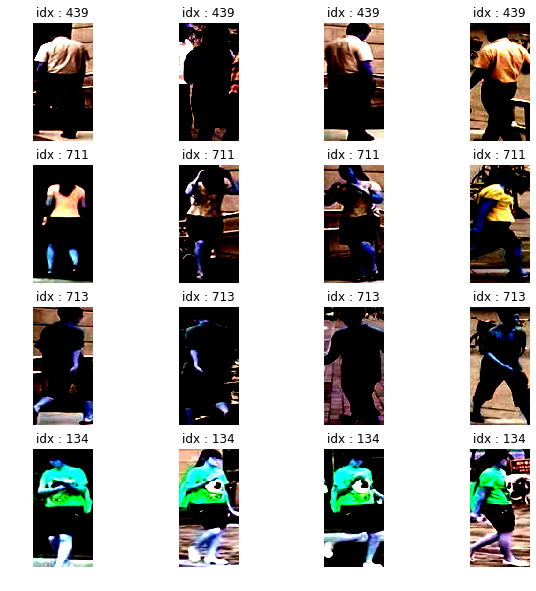

In [6]:
sample_batch, sample_labels = data_gen.sample(plot=True, height=4)

In [7]:
print(sample_batch.shape, sample_labels.shape)

(72, 256, 128, 3) (72, 1)


## Define Learning Rate Schedule

In [8]:
epochs = 200
steps_per_epoch = 100
# schedule = training_utils.step_decay2()

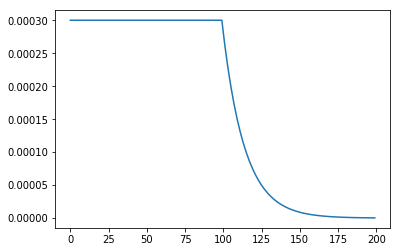

In [9]:
lr = []
for e in range(epochs):
    lr.append(training_utils.step_decay2(e, t0=99, t1=epochs-1)(0))
plt.plot(np.arange(epochs), lr)
plt.show()

## Build Model

In [10]:
model = TriNet(P_param=P_param, K_param=K_param, img_dim=img_dim, margin='soft')

Weights for the model were loaded successfully
margin soft


In [11]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 64, 64)  9408        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 128, 64, 64)  256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 128, 64, 64)  0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
max_poolin

### Train

In [12]:
OUT_DIR = '../../models/trinet-P18K4-soft-margin-200-flip-5'
val_dict = {'lr' : [], 'loss' : [], 'rank-1' : [], 'rank-5' : [], 'mAP' : [],
           'rank-1-flip' : [], 'rank-5-flip' : [], 'mAP-flip' : []}
summary = training_utils.TFSummary(OUT_DIR, val_dict)

In [13]:
for e in range(epochs):
    print("Epoch {}/{}".format(e + 1, epochs))
    it = (e + 1) * steps_per_epoch
    
    # Train model
    schedule = training_utils.step_decay2(e, t0=99, t1=epochs-1)
    val_dict['lr'].append(schedule(0))
    lrate = LearningRateScheduler(schedule, verbose=0)
    
    # fit_generator optimized using queues
    hist = model.fit_generator(data_gen, steps_per_epoch=steps_per_epoch, epochs=1, callbacks=[lrate])
    val_dict['loss'] += hist.history['loss']
    
    summary.update(it, val_name=['lr', 'loss'])
    
    if (e + 1) % 10 == 0 or (e + 1) == epochs:
        # Save model
        path = training_utils.save_weights(model, out_dir=OUT_DIR, it=it)
        
        # Evaluate model
        score = evaluation.get_score(model, img_dim=img_dim, preprocess=True)
        val_dict['rank-1'].append(score['rank'][0])
        val_dict['rank-5'].append(score['rank'][1])
        val_dict['mAP'].append(score['mAP'])
        
        score_flip = evaluation.get_score(model, img_dim=img_dim, preprocess=True, flip="mean")
        val_dict['rank-1-flip'].append(score_flip['rank'][0])
        val_dict['rank-5-flip'].append(score_flip['rank'][1])
        val_dict['mAP-flip'].append(score_flip['mAP'])
        
        summary.update(it, val_name=['rank-1', 'rank-5', 'mAP',
                                     'rank-1-flip', 'rank-5-flip', 'mAP-flip'])

Epoch 1/200
Epoch 1/1
100/100 [==============================] - 71s 708ms/step - loss: 965.6941
Epoch 2/200
Epoch 1/1
100/100 [==============================] - 39s 387ms/step - loss: 406.1673
Epoch 3/200
Epoch 1/1
100/100 [==============================] - 39s 387ms/step - loss: 247.4976
Epoch 4/200
Epoch 1/1
100/100 [==============================] - 39s 387ms/step - loss: 187.7252
Epoch 5/200
Epoch 1/1
100/100 [==============================] - 39s 387ms/step - loss: 140.9737
Epoch 6/200
Epoch 1/1
100/100 [==============================] - 39s 387ms/step - loss: 113.8205
Epoch 7/200
Epoch 1/1
100/100 [==============================] - 39s 387ms/step - loss: 82.6668
Epoch 8/200
Epoch 1/1
100/100 [==============================] - 39s 387ms/step - loss: 70.3201
Epoch 9/200
Epoch 1/1
100/100 [==============================] - 39s 386ms/step - loss: 80.4432
Epoch 10/200
Epoch 1/1
100/100 [==============================] - 39s 386ms/step - loss: 63.8877
Computing gallery embeddings...
1

100/100 [==============================] - 37s 371ms/step - loss: 25.1351
Epoch 52/200
Epoch 1/1
100/100 [==============================] - 37s 372ms/step - loss: 27.5523
Epoch 53/200
Epoch 1/1
100/100 [==============================] - 37s 373ms/step - loss: 28.7940
Epoch 54/200
Epoch 1/1
100/100 [==============================] - 37s 370ms/step - loss: 23.9529
Epoch 55/200
Epoch 1/1
100/100 [==============================] - 37s 369ms/step - loss: 22.9317
Epoch 56/200
Epoch 1/1
100/100 [==============================] - 37s 369ms/step - loss: 25.3866
Epoch 57/200
Epoch 1/1
100/100 [==============================] - 37s 369ms/step - loss: 29.5218
Epoch 58/200
Epoch 1/1
100/100 [==============================] - 38s 377ms/step - loss: 30.8105
Epoch 59/200
Epoch 1/1
100/100 [==============================] - 37s 373ms/step - loss: 31.7803
Epoch 60/200
Epoch 1/1
100/100 [==============================] - 38s 376ms/step - loss: 29.7109
Computing gallery embeddings...
15913/15913 [========

100/100 [==============================] - 37s 374ms/step - loss: 16.1899
Epoch 102/200
Epoch 1/1
100/100 [==============================] - 38s 375ms/step - loss: 12.4563
Epoch 103/200
Epoch 1/1
100/100 [==============================] - 37s 375ms/step - loss: 13.3881
Epoch 104/200
Epoch 1/1
100/100 [==============================] - 38s 375ms/step - loss: 8.4282
Epoch 105/200
Epoch 1/1
100/100 [==============================] - 38s 376ms/step - loss: 8.5655
Epoch 106/200
Epoch 1/1
100/100 [==============================] - 37s 375ms/step - loss: 8.6418
Epoch 107/200
Epoch 1/1
100/100 [==============================] - 38s 375ms/step - loss: 9.3908
Epoch 108/200
Epoch 1/1
100/100 [==============================] - 38s 375ms/step - loss: 5.7071
Epoch 109/200
Epoch 1/1
100/100 [==============================] - 38s 377ms/step - loss: 5.5051
Epoch 110/200
Epoch 1/1
100/100 [==============================] - 38s 378ms/step - loss: 3.7915
Computing gallery embeddings...
15913/15913 [======

100/100 [==============================] - 37s 373ms/step - loss: 1.7268
Epoch 152/200
Epoch 1/1
100/100 [==============================] - 37s 372ms/step - loss: 1.0270
Epoch 153/200
Epoch 1/1
100/100 [==============================] - 38s 376ms/step - loss: 1.2329
Epoch 154/200
Epoch 1/1
100/100 [==============================] - 38s 377ms/step - loss: 2.2605
Epoch 155/200
Epoch 1/1
100/100 [==============================] - 38s 376ms/step - loss: 1.8146
Epoch 156/200
Epoch 1/1
100/100 [==============================] - 38s 377ms/step - loss: 1.8056
Epoch 157/200
Epoch 1/1
100/100 [==============================] - 38s 377ms/step - loss: 1.4331
Epoch 158/200
Epoch 1/1
100/100 [==============================] - 37s 374ms/step - loss: 1.3707
Epoch 159/200
Epoch 1/1
100/100 [==============================] - 38s 376ms/step - loss: 0.8621
Epoch 160/200
Epoch 1/1
100/100 [==============================] - 37s 373ms/step - loss: 0.9414
Computing gallery embeddings...
15913/15913 [=========

## Test

In [16]:
model.set_weights(np.load('../../models/trinet-P18K4-soft-margin-200-flip/20000.npy'))

In [17]:
score = evaluation.get_score(model, img_dim=img_dim, preprocess=True)

Computing gallery embeddings...
15913/15913 [==============================] - 57s 4ms/step
Computing query embeddings...
3368/3368 [==============================] - 10s 3ms/step
Computing rank ([1, 5]) and mAP (True) scores...
3368/3368 [==============================] - 62s 19ms/step
rank-1: 85.63
rank-5: 94.60
mAP: 70.82


In [12]:
ensemble = models.MetricEnsemble(model, ['../../models/trinet-P18K4-soft-margin-200-flip/20000.npy',
                                                   '../../models/trinet-P18K4-soft-margin-200-flip-2/20000.npy',
                                         '../../models/trinet-P18K4-soft-margin-200-flip-3/20000.npy',
                                         '../../models/trinet-P18K4-soft-margin-200-flip-4/20000.npy'
                                        ])

# ensemble = models.MetricEnsemble(model, ['../../models/trinet-P18K4-soft-margin-200-crop-flip/20000.npy',
#                                          '../../models/trinet-P18K4-soft-margin-200-crop-flip/20000.npy'])

Model 1 successfully loaded from ../../models/trinet-P18K4-soft-margin-200-flip/20000.npy
Model 2 successfully loaded from ../../models/trinet-P18K4-soft-margin-200-flip-2/20000.npy
Model 3 successfully loaded from ../../models/trinet-P18K4-soft-margin-200-flip-3/20000.npy
Model 4 successfully loaded from ../../models/trinet-P18K4-soft-margin-200-flip-4/20000.npy


In [13]:
ensemble.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 256, 128, 3)  0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 256, 128, 3)  0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 256, 128, 3)  0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 256, 128, 3)  0                                            
__________________________________________________________________________________________________
model_1 (M

In [15]:
score = evaluation.get_score(ensemble, img_dim=img_dim, preprocess=True)

Computing gallery embeddings...
15913/15913 [==============================] - 135s 8ms/step
Computing query embeddings...
3368/3368 [==============================] - 30s 9ms/step
Computing rank ([1, 5]) and mAP (True) scores...
3368/3368 [==============================] - 203s 60ms/step
rank-1: 89.79
rank-5: 96.41
mAP: 77.85
